### Import Libraries

In [3]:
import numpy as np
import xarray as xr
import hsmm_mvpy as hmp
from pathlib import Path
from mne import channels

### Load data

In [2]:
# Amount of cores to use in multiprocessing
cpus = 8

eeg_data = xr.load_dataset('data/sat1/data.nc')

# Set up montage according to 10-20 system
montage = dict(channels.make_standard_montage('easycap-M1').get_positions())['ch_pos']

# Load x and y positions of electrodes
positions = np.array([montage[x][:2] for x in eeg_data['electrodes'].values])


### Prepare data

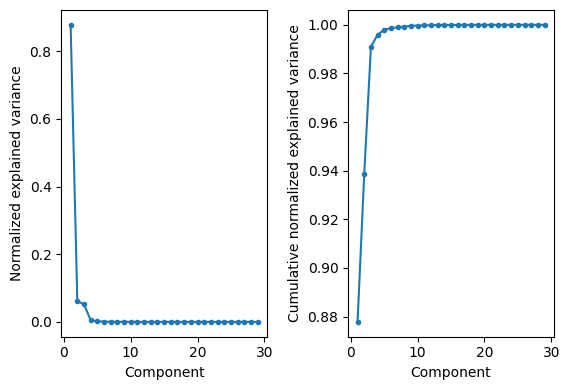

In [4]:
# Transform data into principal component (PC) space
# will ask in a pop-up how many components to keep
# selection depends on data size, choose number at cutoff (90/99%) or at 'elbow' point
hmp_data = hmp.utils.transform_data(eeg_data)

### Initialize model

In [5]:
# Select only condition for accuracy, not speed
hmp_data = hmp.utils.condition_selection(hmp_data, eeg_data, 'AC')
model = hmp.models.hsmm(hmp_data, eeg_data, bump_width=50, cpus=cpus)

Fitting 112 models using grid search


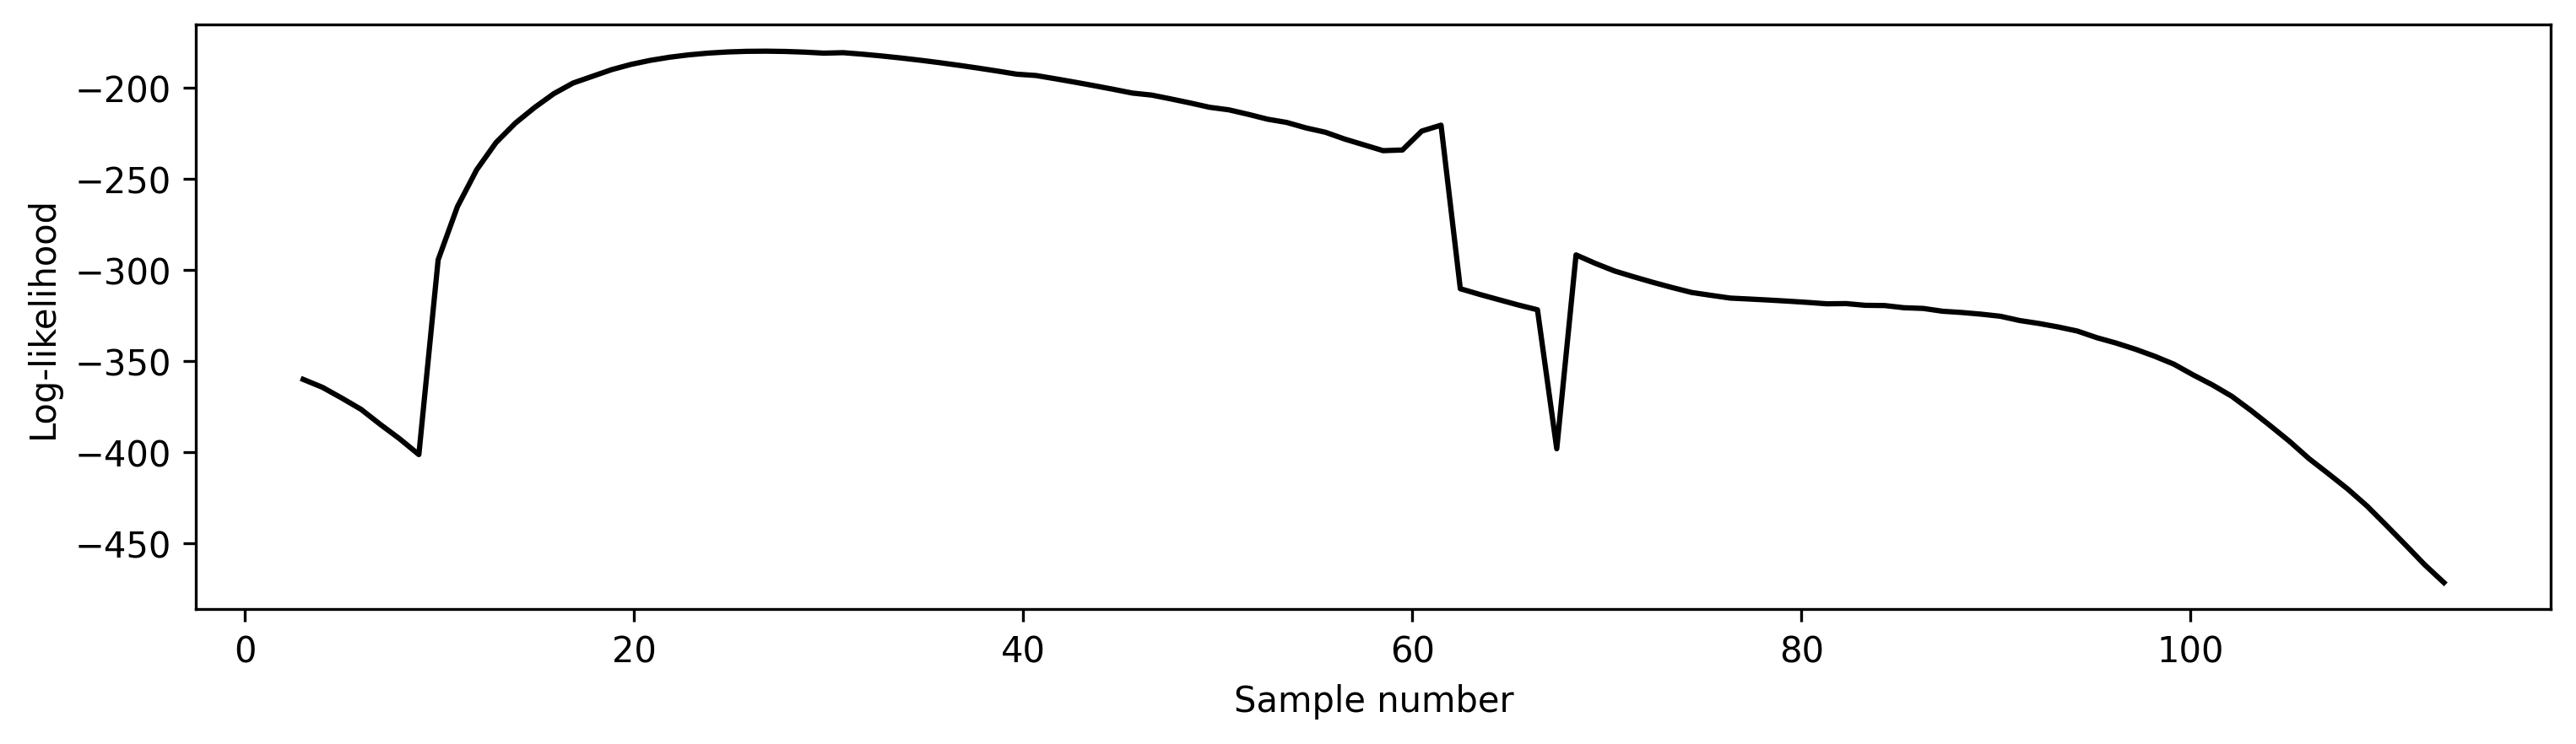

In [6]:
model.sliding_bump(method=None)

In [ ]:
%%timeit
bests = model.backward_estimation(max_fit=max_fit)